In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [ ]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(torch.tensor(list(imgb), dtype=torch.uint8)).float()/255.

In [ ]:
url = 'https://distill.pub/2020/attribution-baselines/data_gen/data/goldfinch/integrated_gradients/interpolated_image_1.00.png'
gfim = download_image(url)

In [ ]:
#gfim[1, 0:10, 0:10] = 1.0


<AxesSubplot: >

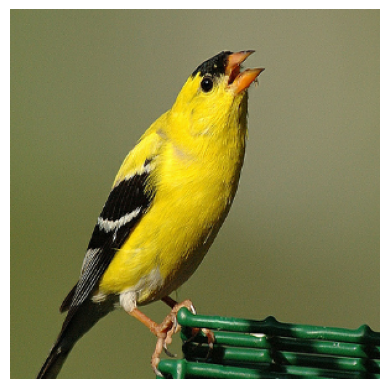

In [ ]:
show_image(gfim)

In [ ]:
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

url, filename = (url, "goldfinch.jpg")
urllib.request.urlretrieve(url, filename)
img = Image.open(filename).convert('RGB')
tensor = transform(img).unsqueeze(0) # transform and add batch dimension


In [ ]:
url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", 
                 "imagenet_classes.txt")
urllib.request.urlretrieve(url, filename) 
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

def print_top5(probabilities):
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())


In [ ]:
from torchvision.transforms import *
transform = Compose([
    Resize(size=341, max_size=None, antialias=None),
    CenterCrop(size=(299, 299)),
    Normalize(mean=torch.tensor([0.5000, 0.5000, 0.5000]), std=torch.tensor([0.5000, 0.5000, 0.5000]))]
)

In [ ]:
transform(gfim).shape

torch.Size([3, 299, 299])

In [ ]:
def ev(model,x):
    with torch.no_grad():
        model.eval()
        return model(x)


print_top5(ev(model, transform(gfim)[None]).squeeze().softmax(dim=-1))

goldfinch 0.9088183641433716
brambling 0.0011592090595513582
whistle 0.0006740852259099483
sulphur butterfly 0.0006108328816480935
rock beauty 0.0005938473623245955


In [ ]:

def get_transform(model):
    config = resolve_data_config({}, model=model)
    print(config)
    transform = create_transform(**config)
    for idx in [e for e,t in enumerate(transform.transforms) if isinstance(t,ToTensor)]:
        del transform.transforms[idx]
    return transform

In [ ]:
t=get_transform(model)

{'input_size': (3, 299, 299), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.875}


In [ ]:
t

Compose(
    Resize(size=341, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(299, 299))
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)

## inception v4

In [ ]:
model4 = timm.create_model('inception_v4', pretrained=True).eval()

In [ ]:
norm=get_transform(model4)

{'input_size': (3, 299, 299), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.875}


In [ ]:
from torch import tensor
def top5(model, im): return print_top5(ev(model, im[None,...]).squeeze().softmax(dim=-1))

In [ ]:
norm=Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
top5(model4,norm(gfim.cpu()))

goldfinch 0.9271080493927002
sea snake 0.001083548180758953
brambling 0.0007647138554602861
admiral 0.0003963029012084007
shopping basket 0.0003559035249054432


### Test on mixed with balck

goldfinch 0.9386211037635803
brambling 0.0011130849597975612
kite 0.000840033870190382
toucan 0.0008119552512653172
sea snake 0.0008030047756619751


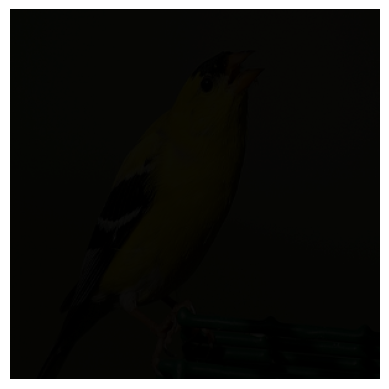

In [ ]:
base=torch.zeros_like(gfim)
alpha=0.05
r = base + alpha*(gfim-base)
show_image(r)
top5(model4, norm(r))

In [ ]:
norm

Normalize(mean=tensor([0.50, 0.50, 0.50]), std=tensor([0.50, 0.50, 0.50]))

In [ ]:
model4.to('cuda')
gfim = gfim.to('cuda')
base=torch.zeros_like(gfim)
alphas = torch.linspace(0.0, 0.1, 50)
probs = []
for alpha in alphas:
    im = base + alpha*(norm(gfim)-base)
    p = ev(model4, im[None,...]).squeeze().softmax(dim=-1)[11]
    probs.append(p)
    #show_image(im)

[<matplotlib.lines.Line2D>]

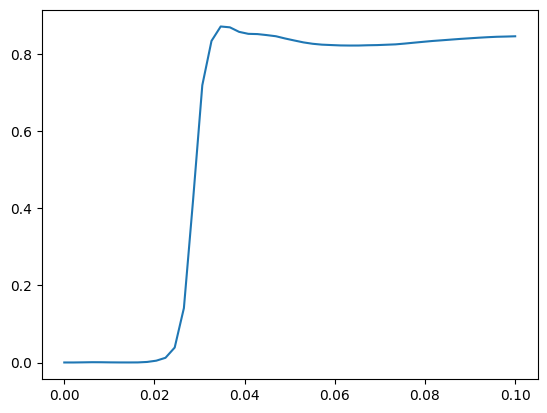

In [ ]:
plt.plot(alphas, torch.stack(probs).cpu(), )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot: >, torch.Size([3, 299, 299]), tensor(0.04, device='cuda:0'))

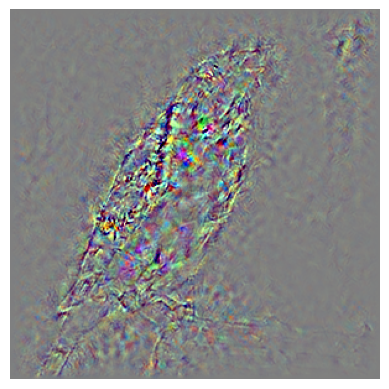

In [ ]:
#for alpha in alphas:
alpha=0.03
im = base + alpha*(norm(gfim)-base)
im.requires_grad_(True)
p = F.cross_entropy(model4(im[None,...]), tensor([11],device='cuda'))
p.backward()
show_image(im.grad+0.5), im.grad.shape, im.grad.abs().mean()

In [ ]:
im.grad

tensor([[[     0.00,      0.00,      0.00,  ...,      0.00,      0.00,      0.00],
         [    -0.00,     -0.00,      0.00,  ...,      0.00,      0.00,      0.00],
         [     0.00,      0.00,      0.00,  ...,     -0.00,      0.00,     -0.00],
         ...,
         [    -0.00,     -0.00,     -0.00,  ...,      0.00,      0.00,      0.00],
         [    -0.00,     -0.00,     -0.00,  ...,      0.00,      0.00,      0.00],
         [    -0.00,     -0.00,     -0.00,  ...,      0.00,      0.00,      0.00]],

        [[    -0.00,      0.00,      0.00,  ...,     -0.00,      0.00,      0.00],
         [    -0.00,     -0.00,      0.00,  ...,     -0.00,     -0.00,     -0.00],
         [     0.00,      0.00,      0.00,  ...,      0.00,     -0.00,     -0.00],
         ...,
         [    -0.00,     -0.00,     -0.00,  ...,      0.00,      0.00,      0.00],
         [    -0.00,     -0.00,     -0.00,  ...,      0.00,      0.00,      0.00],
         [    -0.00,      0.00,     -0.00,  ...,      0.0

In [ ]:
 
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.stack(probs).cpu()

tensor([    0.00,     0.00,     0.00,     0.63,     0.85,     0.84,     0.82,     0.82,     0.83,     0.84,     0.85,     0.85,     0.85,
            0.85,     0.84,     0.84,     0.85,     0.85,     0.85,     0.85,     0.85,     0.85,     0.85,     0.85,     0.85,     0.85,
            0.85,     0.85,     0.85,     0.85,     0.85,     0.85,     0.85,     0.85,     0.85,     0.84,     0.84,     0.85,     0.85,
            0.85,     0.85,     0.85,     0.85,     0.85,     0.86,     0.86,     0.86,     0.86,     0.86,     0.86])

In [ ]:
model4(gfim[None]).argmax()

tensor(11)

## gradienty
